Récupération des données brutes depuis 'data_tv'...
Filtrage : Visualisation des 10 premières classes sur 100.
----- Dataset Description -----
Train data: 5000 images
Dimensions détectées : 32x32 pixels, 3 canaux
Format PyTorch (Channels First) : Non
Number of classes: 10
--------------------------------


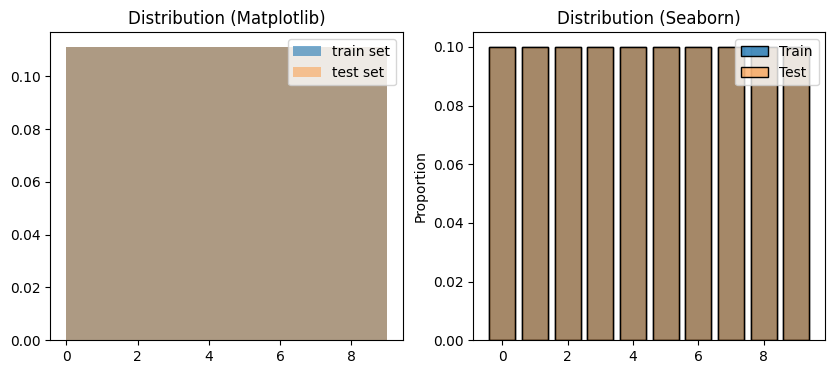

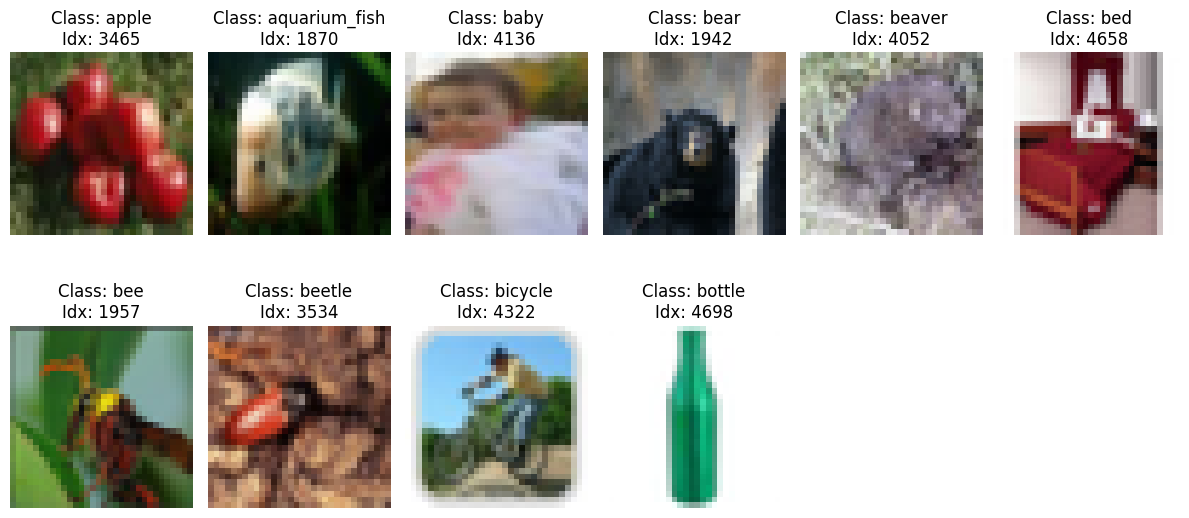

Variables définies : 100 classes.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4088/3585800566.py:256: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Démarrage de l'entraînement...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.508500,1.079176,0.874000
2,0.965400,0.532579,0.905100
3,0.715700,0.434551,0.914400


Terminé ! Modèle sauvegardé.


In [4]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import CIFAR100
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import (CenterCrop, Compose, Normalize, 
                                    RandomHorizontalFlip, RandomResizedCrop, 
                                    Resize, ToTensor)
from sklearn.metrics import accuracy_score
import random as rd
import matplotlib.pyplot as plt
from transformers import default_data_collator
import seaborn as sns # Indispensable pour ta fonctionp
def describe_image_dataset(x_train, y_train, x_test, y_test, class_names=None, cmap="gray"):
    """
    Version corrigée pour gérer les tenseurs PyTorch (C, H, W).
    """

    # --- Gestion des Tenseurs PyTorch ---
    # Si c'est un tenseur PyTorch, on le convertit en Numpy pour les stats
    if isinstance(x_train, torch.Tensor):
        x_train_np = x_train.cpu().numpy()
        x_test_np = x_test.cpu().numpy()
    else:
        x_train_np = x_train
        x_test_np = x_test

    # --- Détection du format (Channels First vs Last) ---
    # PyTorch est (N, C, H, W), on vérifie si la dimension 1 est petite (1 ou 3)
    channels_first = False
    if x_train_np.ndim == 4 and x_train_np.shape[1] in [1, 3] and x_train_np.shape[2] > 3:
        # Format (N, C, H, W) détecté
        channels_first = True
        N_train, C, H, W = x_train_np.shape
        N_test = x_test_np.shape[0]
    elif x_train_np.ndim == 4:
        # Format classique (N, H, W, C)
        N_train, H, W, C = x_train_np.shape
        N_test = x_test_np.shape[0]
    elif x_train_np.ndim == 3:
        # Grayscale (N, H, W)
        N_train, H, W = x_train_np.shape
        C = 1
        N_test = x_test_np.shape[0]
    else:
        raise ValueError("Format d'image non reconnu.")

    # Nombre de classes
    classes = np.unique(y_train)
    N_classes = len(classes)

    print("----- Dataset Description -----")
    print(f"Train data: {N_train} images")
    print(f"Dimensions détectées : {H}x{W} pixels, {C} canaux")
    print(f"Format PyTorch (Channels First) : {'Oui' if channels_first else 'Non'}")
    print(f"Number of classes: {N_classes}")
    print("--------------------------------")

    # --- Distribution histograms (Matplotlib) ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(y_train, density=True, alpha=0.6, label='train set', bins=N_classes)
    plt.hist(y_test, density=True, alpha=0.4, label='test set', bins=N_classes)
    plt.title("Distribution (Matplotlib)")
    plt.legend()

    # --- Distribution histograms (Seaborn) ---
    plt.subplot(1, 2, 2)
    sns.histplot(y_train, stat='proportion', discrete=True, alpha=.8, shrink=.8, label='Train')
    sns.histplot(y_test, stat='proportion', discrete=True, alpha=.5, shrink=.8, label='Test')
    plt.title("Distribution (Seaborn)")
    plt.legend()
    plt.show()

    # --- Display example images by class ---
    fig = plt.figure(figsize=(12, 6))

    for i in range(N_classes):
        ax = fig.add_subplot(2, (N_classes + 1) // 2 + 1, i + 1)

        # Sélection d'un index aléatoire pour la classe i
        indices = np.where(y_train == i)[0]
        if len(indices) > 0:
            sample_index = rd.choice(indices)
            
            # Récupération de l'image (toujours en numpy ici)
            img = x_train_np[sample_index]

            # CORRECTION CRUCIALE : Transposition si Channels First (C, H, W) -> (H, W, C)
            if channels_first:
                img = np.transpose(img, (1, 2, 0))

            # Si l'image est en niveaux de gris (H, W, 1), on squeeze pour avoir (H, W)
            if C == 1 and img.ndim == 3:
                img = img.squeeze()

            # Normalisation pour affichage (si les valeurs sont hors de [0,1])
            # imshow aime les float entre [0,1] ou int entre [0,255]
            if img.max() > 1.0 and img.dtype != np.uint8:
                img = img / 255.0
            elif img.min() < 0: # Cas où l'image est normalisée (ex: mean/std)
                img = (img - img.min()) / (img.max() - img.min())

            ax.imshow(img, cmap=cmap if C == 1 else None)
            
            label_name = class_names[i] if class_names is not None else str(i)
            ax.set_title(f"Class: {label_name}\nIdx: {sample_index}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
print("Récupération des données brutes depuis 'data_tv'...")

# On pointe vers le dossier existant. download=True vérifie juste la présence des fichiers.
ds_visu_train = CIFAR100(root='./data_tv', train=True, download=True)
ds_visu_test = CIFAR100(root='./data_tv', train=False, download=True)

# Extraction des tableaux Numpy (Images et Labels)
x_train_full = ds_visu_train.data        # (50000, 32, 32, 3)
y_train_full = np.array(ds_visu_train.targets)
x_test_full = ds_visu_test.data
y_test_full = np.array(ds_visu_test.targets)

# Récupération des noms de classes (ex: 'apple', 'aquarium_fish'...)
class_names = ds_visu_train.classes

# ==========================================
# 2. FILTRAGE (Pour ne voir que 10 classes)
# ==========================================
# CIFAR-100 est illisible si on affiche tout d'un coup.
nb_classes_visu = 10
print(f"Filtrage : Visualisation des {nb_classes_visu} premières classes sur 100.")

# Création des masques pour ne garder que les labels 0 à 9
mask_train = y_train_full < nb_classes_visu
mask_test = y_test_full < nb_classes_visu

# Application du filtre
x_train_sub = x_train_full[mask_train]
y_train_sub = y_train_full[mask_train]
x_test_sub = x_test_full[mask_test]
y_test_sub = y_test_full[mask_test]

# On garde aussi seulement les noms correspondants
class_names_sub = class_names[:nb_classes_visu]

# ==========================================
# 3. AFFICHAGE
# ==========================================
# Appel de votre fonction de description
describe_image_dataset(
    x_train_sub, y_train_sub, 
    x_test_sub, y_test_sub, 
    class_names=class_names_sub
)

# ==========================================
# 2. PRÉPARATION DU MODÈLE
# ==========================================
# On réutilise les datasets chargés pour la visu (pour ne pas recharger 2 fois)
train_ds_raw = ds_visu_train
test_ds_raw = ds_visu_test

# On définit 'labels' et les dictionnaires de mapping requis par le modèle
labels = train_ds_raw.classes
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

print(f"Variables définies : {len(labels)} classes.")
model_checkpoint = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_checkpoint)
model = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# ==========================================
# 3. TRANSFORMS & WRAPPER
# ==========================================
# On doit créer une classe Wrapper pour que Torchvision soit compatible
# avec ce que le Trainer Hugging Face attend (dictionnaire avec 'pixel_values')

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
normalize = Normalize(mean=image_mean, std=image_std)

# Transformations (Augmentation pour Train)
train_transforms = Compose([
    RandomResizedCrop(size), 
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

# Transformations (Simple resize pour Val)
val_transforms = Compose([
    Resize(size), 
    CenterCrop(size),
    ToTensor(),
    normalize,
])

class ViTDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # image est une PIL Image ici
        pixel_values = self.transform(image)
        
        # Le Trainer attend un dictionnaire
        return {
            "pixel_values": pixel_values,
            "labels": label
        }

# Création des datasets finaux compatibles Trainer
train_dataset = ViTDatasetWrapper(train_ds_raw, train_transforms)
test_dataset = ViTDatasetWrapper(test_ds_raw, val_transforms)

# ==========================================
# 4. CONFIGURATION & ENTRAÎNEMENT
# ==========================================

from transformers import default_data_collator

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(labels, predictions))

args = TrainingArguments(
    output_dir="vit_cifar100_output",
    remove_unused_columns=False,
    
    eval_strategy="epoch",          
    
    save_strategy="no",             
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    dataloader_num_workers=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
)

print("Démarrage de l'entraînement...")
trainer.train()

trainer.save_model("vit_cifar100_final_model")
print("Terminé ! Modèle sauvegardé.")

Loss finale Train: 0.8109
Loss finale Val:   0.4346
Acc finale Val:    91.44%


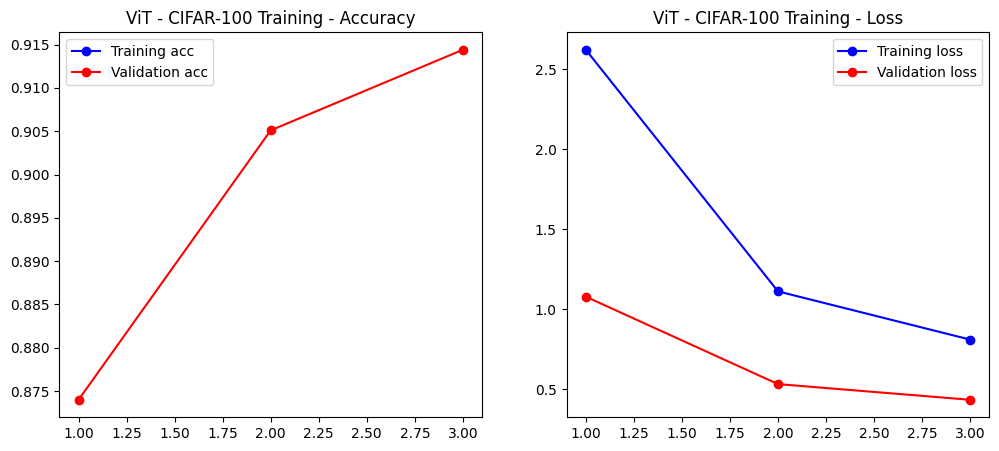

In [9]:
def plot_history(history, title="Training History"):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# 1. Extraction des logs depuis l'historique du Trainer
log_history_vit = trainer.state.log_history

# Initialisation des listes
train_loss = []
val_loss = []
val_acc = []
epochs_val = []

# On parcourt les logs pour séparer Train et Val
# Note : Le Trainer logue la 'loss' (train) fréquemment, et 'eval_loss' (val) à la fin de chaque époque.
for entry in log_history_vit:
    if 'eval_loss' in entry:
        # C'est une entrée de validation (fin d'époque)
        val_loss.append(entry['eval_loss'])
        val_acc.append(entry['eval_accuracy'])
        epochs_val.append(entry['epoch'])
    elif 'loss' in entry:
        # C'est une entrée d'entraînement.
        # Pour simplifier le plot, on pourrait garder toutes les valeurs, 
        # mais ici on va garder seulement la dernière valeur connue avant l'évaluation
        # ou faire une moyenne si on voulait être plus précis.
        # Ici, on stocke tout temporairement, on alignera après.
        pass

# Pour aligner le Training Loss sur le Validation Loss (1 point par époque),
# on va prendre la moyenne des loss d'entraînement pour chaque époque entière.
# (C'est une approximation pour l'affichage propre)
train_loss_epoch = []
current_epoch_losses = []
current_epoch = 0

for entry in log_history_vit:
    if 'loss' in entry:
        current_epoch_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        # Fin d'époque détectée via l'eval
        if current_epoch_losses:
            train_loss_epoch.append(sum(current_epoch_losses) / len(current_epoch_losses))
            current_epoch_losses = [] # Reset pour l'époque suivante

# Création du dictionnaire compatible avec votre fonction
history_cifar_vit = {
    # Astuce : Comme HF ne calcule pas l'accuracy train par défaut, 
    # on met des NaN (Not a Number) pour ne pas fausser le graphique.
    'train_acc': [float('nan')] * len(val_acc), 
    'val_acc': val_acc,
    'train_loss': train_loss_epoch,
    'val_loss': val_loss
}

print(f"Loss finale Train: {history_cifar_vit['train_loss'][-1]:.4f}")
print(f"Loss finale Val:   {history_cifar_vit['val_loss'][-1]:.4f}")
print(f"Acc finale Val:    {history_cifar_vit['val_acc'][-1]:.2%}")

# 2. Affichage avec votre fonction
# On ajoute un petit try/except au cas où les listes n'aient pas exactement la même taille (arrondi d'époque)
try:
    plot_history(history_cifar_vit, title="ViT - CIFAR-100 Training")
except ValueError as e:
    print(f"Erreur de dimension dans le plot (souvent dû à l'arrêt anticipé ou logging steps) : {e}")
    # Fallback simple
    plt.figure(figsize=(6,4))
    plt.plot(history_cifar_vit['val_acc'], 'ro-', label='Validation Acc')
    plt.title("Validation Accuracy Only")
    plt.legend()
    plt.show()


## ResNet50

On va utiliser ResNet50 pour avoir un camparatif des perfomances. 

In [6]:
import torch
import torch.nn as nn
from torchvision import models

# ==========================================
# 1. CRÉATION DU MODÈLE CNN (ResNet-50)
# ==========================================
print("Téléchargement de ResNet-50 (poids ImageNet)...")

# On charge ResNet-50 pré-entraîné
# 'DEFAULT' charge les meilleurs poids disponibles (IMAGENET1K_V2)
cnn_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# On doit modifier la dernière couche (la tête) car ImageNet a 1000 classes, 
# et CIFAR-100 en a 100.
num_ftrs = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_ftrs, 100) # 100 classes pour CIFAR-100

# ==========================================
# 2. LE WRAPPER "HUGGING FACE COMPATIBLE"
# ==========================================
# Le Trainer de Hugging Face s'attend à ce que le modèle :
# 1. Accepte des arguments nommés (pixel_values, labels)
# 2. Renvoie un dictionnaire contenant au moins "loss" et "logits"

class HFResNetWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        
        # On déplace le modèle sur GPU si dispo
        if torch.cuda.is_available():
            self.model.cuda()

    def forward(self, pixel_values, labels=None):
        # Forward pass standard du CNN
        logits = self.model(pixel_values)
        
        out = {"logits": logits}
        
        # Calcul de la loss si les labels sont fournis (entraînement)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            out["loss"] = loss
            
        return out

# On emballe notre ResNet
model_cnn = HFResNetWrapper(cnn_model)

# ==========================================
# 3. CONFIGURATION & ENTRAÎNEMENT
# ==========================================
# On réutilise exactement les mêmes arguments pour que la comparaison soit juste (Apple-to-Apple)
# Sauf le dossier de sortie

args_cnn = TrainingArguments(
    output_dir="resnet50_cifar100_results",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="no",              # Toujours pour sauver le disque
    learning_rate=5e-5,              # Même LR que le ViT pour comparer
    per_device_train_batch_size=16,  # Même batch size
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # Même nombre d'époques
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    dataloader_num_workers=2
)

trainer_cnn = Trainer(
    model=model_cnn,
    args=args_cnn,
    train_dataset=train_dataset,     # On réutilise ton dataset wrapper existant
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, # Ta fonction existante
    data_collator=default_data_collator,
)

print(" Démarrage de l'entraînement ResNet-50...")
trainer_cnn.train()

# Sauvegarde manuelle (car le Wrapper n'a pas de méthode save_pretrained native)
torch.save(cnn_model.state_dict(), "resnet50_cifar100_final.pth")
print(" Modèle ResNet sauvegardé.")

Téléchargement de ResNet-50 (poids ImageNet)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/neboit/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s] 


🚀 Démarrage de l'entraînement ResNet-50...


Epoch,Training Loss,Validation Loss,Accuracy
1,2.028000,1.193022,0.659800
2,1.768000,0.902585,0.732600
3,1.603200,0.823492,0.756300


✅ Modèle ResNet sauvegardé.


Loss finale Train: 1.6601
Loss finale Val:   0.8235
Acc finale Val:    75.63%


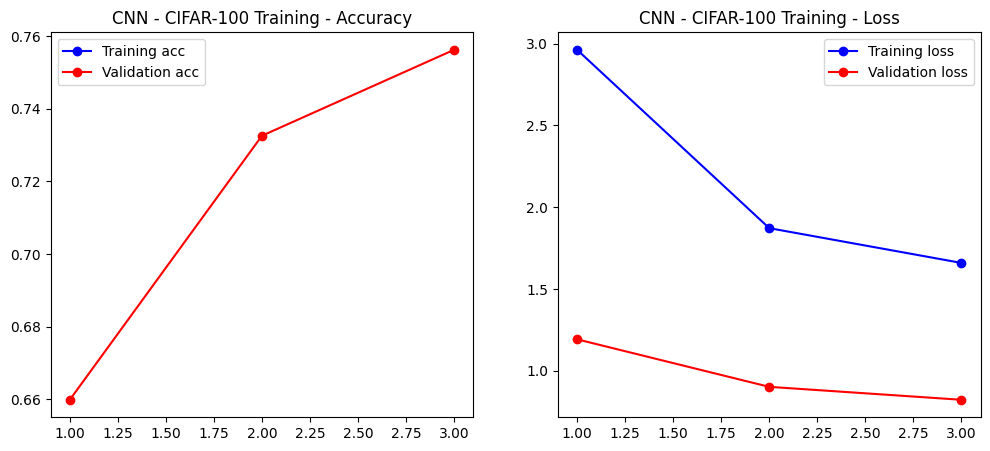

In [8]:
# 1. Extraction des logs depuis l'historique du Trainer
log_history_cnn = trainer_cnn.state.log_history

# Initialisation des listes
train_loss = []
val_loss = []
val_acc = []
epochs_val = []

# On parcourt les logs pour séparer Train et Val
# Note : Le Trainer logue la 'loss' (train) fréquemment, et 'eval_loss' (val) à la fin de chaque époque.
for entry in log_history_cnn:
    if 'eval_loss' in entry:
        # C'est une entrée de validation (fin d'époque)
        val_loss.append(entry['eval_loss'])
        val_acc.append(entry['eval_accuracy'])
        epochs_val.append(entry['epoch'])
    elif 'loss' in entry:
        # C'est une entrée d'entraînement.
        # Pour simplifier le plot, on pourrait garder toutes les valeurs, 
        # mais ici on va garder seulement la dernière valeur connue avant l'évaluation
        # ou faire une moyenne si on voulait être plus précis.
        # Ici, on stocke tout temporairement, on alignera après.
        pass

# Pour aligner le Training Loss sur le Validation Loss (1 point par époque),
# on va prendre la moyenne des loss d'entraînement pour chaque époque entière.
# (C'est une approximation pour l'affichage propre)
train_loss_epoch = []
current_epoch_losses = []
current_epoch = 0

for entry in log_history_cnn:
    if 'loss' in entry:
        current_epoch_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        # Fin d'époque détectée via l'eval
        if current_epoch_losses:
            train_loss_epoch.append(sum(current_epoch_losses) / len(current_epoch_losses))
            current_epoch_losses = [] # Reset pour l'époque suivante

# Création du dictionnaire compatible avec votre fonction
history_cifar_cnn = {
    # Astuce : Comme HF ne calcule pas l'accuracy train par défaut, 
    # on met des NaN (Not a Number) pour ne pas fausser le graphique.
    'train_acc': [float('nan')] * len(val_acc), 
    'val_acc': val_acc,
    'train_loss': train_loss_epoch,
    'val_loss': val_loss
}

print(f"Loss finale Train: {history_cifar_cnn['train_loss'][-1]:.4f}")
print(f"Loss finale Val:   {history_cifar_cnn['val_loss'][-1]:.4f}")
print(f"Acc finale Val:    {history_cifar_cnn['val_acc'][-1]:.2%}")

# 2. Affichage avec votre fonction
# On ajoute un petit try/except au cas où les listes n'aient pas exactement la même taille (arrondi d'époque)
try:
    plot_history(history_cifar_cnn, title="CNN - CIFAR-100 Training")
except ValueError as e:
    print(f"Erreur de dimension dans le plot (souvent dû à l'arrêt anticipé ou logging steps) : {e}")
    # Fallback simple
    plt.figure(figsize=(6,4))
    plt.plot(history_cifar_cnn['val_acc'], 'ro-', label='Validation Acc')
    plt.title("Validation Accuracy Only")
    plt.legend()
    plt.show()


## Comparaison de deux modèles

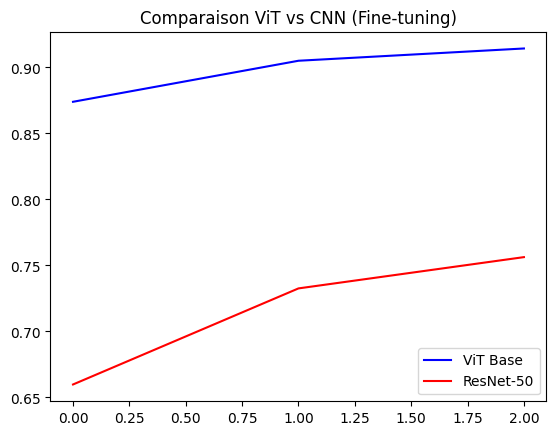

In [10]:
# Plot Comparatif
plt.plot(history_cifar_vit['val_acc'], 'b-', label='ViT Base')
plt.plot(history_cifar_cnn['val_acc'], 'r-', label='ResNet-50')
plt.title("Comparaison ViT vs CNN (Fine-tuning)")
plt.legend()
plt.show()